# Parameters

In [1]:
data_dir = './data/'
nodes = [100, 200, 200, 200]  # Nodes in hidden layers, default [100,200,200,200]
device = 'cuda:1'  # Device to use by pytorch, default cuda:1
epochs = 100  # Epochs in Pytorch, default 100

# Load data

In [2]:
import pandas as pd

# data_path = data_dir + "train2_norm_sampled_10k.pkl"  # 10k
# data_path = data_dir + "train2_norm_sampled_100k.pkl"  # 100k
# data_path = data_dir + "train2_norm_sampled_1M.pkl"  # 1M
# data_path = data_dir + "train2_norm_sampled.pkl"  # 3.09M, upsampled & downsampled, 3.090,617 samples
# data_path = data_dir + "train2_norm_resampled.pkl"  # all upsampled without downsampling

# df_train = df_train = pd.read_pickle(data_path)

# df_train = pd.read_pickle(data_dir + "train2_norm_sampled_test_0.05.pkl")
df_train = pd.read_pickle(data_dir + "train2_norm_sampled_train_0.95.pkl")
df_test = pd.read_pickle(data_dir + "train2_norm_sampled_test_0.05.pkl")

In [3]:
import torch
from torch.autograd import Variable

X_train = torch.tensor(df_train[["CO+CO2", "H*", "O*", "C*"]].values, device=device)
y_train = torch.tensor(df_train[["n2_out"+ f"{v}" for v in range(1, 51)]].values, device=device)
X_test = torch.tensor(df_test[["CO+CO2", "H*", "O*", "C*"]].values, device=device)
y_test = torch.tensor(df_test[["n2_out"+ f"{v}" for v in range(1, 51)]].values, device=device)

print(f"Num of training samples: {len(X_train)}, num of testing samples {len(X_test)}")

Num of training samples: 2615048, num of testing samples 137635


In [4]:
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline


def plot_3d_subplot(x, y, savepath):
    '''
     x,y type: numpy 2darray
    '''
    fig = plt.figure(figsize=(20, 10))
    xline, yline, zline1, zline2 = x[:, 0], x[:, 1], y[:, 0], y[:, 1]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('CO+CO2', fontsize=10)
    ax1.set_ylabel('N2', fontsize=10)
    ax1.set_zlabel('W1', fontsize=10)
    ax1.scatter3D(xline, yline, zline1, c=zline1, cmap=cm.coolwarm)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_xlabel('CO+CO2', fontsize=10)
    ax2.set_ylabel('N2', fontsize=10)
    ax2.set_zlabel('W2', fontsize=10)
    ax2.scatter3D(xline, yline, zline2, c=zline2, cmap=cm.coolwarm)

    #plt.savefig(savepath)

Start time = 2021-11-27 23:07:08.102337
End time = 2021-11-27 23:07:08.256664


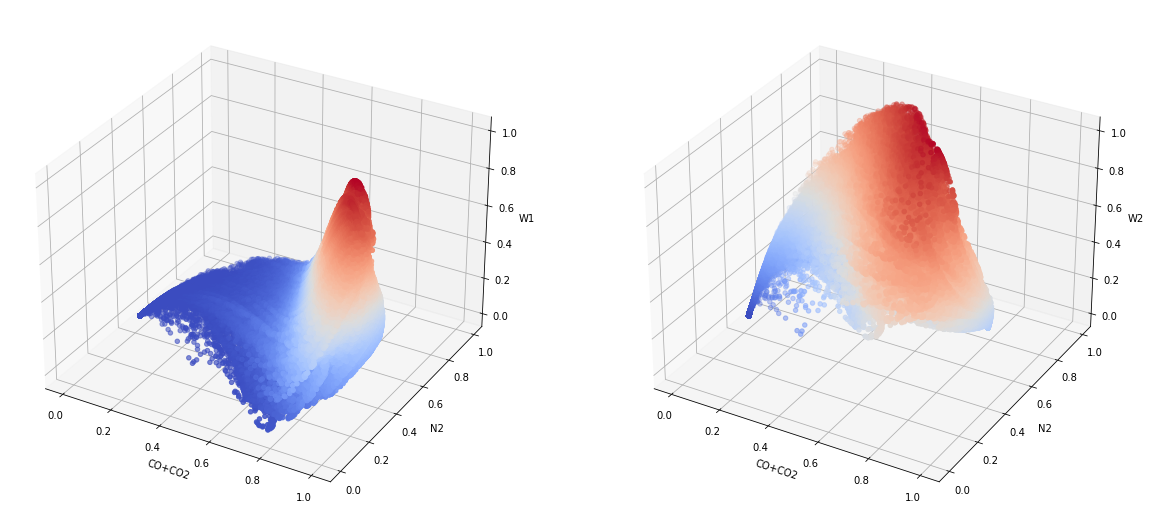

In [5]:
import datetime

print(f"Start time = {datetime.datetime.now()}")
plot_3d_subplot(X_test[:, :2].cpu().data.numpy(), y_test.cpu().data.numpy(), f"result/3D_plot-ann2-W-target.png")
print(f"End time = {datetime.datetime.now()}")

# Create model
## Create a new model

In [6]:
def create_model(n_input, n_output, nodes, device='cpu'):
    modules = []

    # add first hidden layer (and input layer)
    modules.append(torch.nn.Linear(n_input, nodes[0]))
    modules.append(torch.nn.LeakyReLU())

    for i in range(1, len(nodes)):
        modules.append(torch.nn.Linear(nodes[i-1], nodes[i]))
        modules.append(torch.nn.LeakyReLU())

    # add output layer
    modules.append(torch.nn.Linear(nodes[-1], n_output))

    model = torch.nn.Sequential(*modules).to(device)

    return model


def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)

In [7]:
model = create_model(X_train.shape[1], y_train.shape[1], nodes, device=device)

## Load pretrained model

In [8]:
def load_model(X_train, y_train, nodes, device, model_path):
    model = create_model(X_train.shape[1], y_train.shape[1], nodes, device=device)
    model.load_state_dict(torch.load(model_path))
    return model.eval()

In [10]:
# model = load_model(X_train.shape[1], y_train.shape[1], nodes, device=device, model_path)

# Model training

In [18]:
n_epoch = 100
lr = 0.01  # 0.001
lr_decay = 0.96
momentum = 0.9
BATCH_SIZE = 128
save_path = './'
eval_interval = 1

## Define dataloader

In [12]:
import torch.utils.data as Data

# Process training data
torch.manual_seed(1)    # reproducible
train_dataset = Data.TensorDataset(X_train, y_train)
loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False, )

## Set optimizer

In [19]:
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # only works with mean, not sum, loss 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)  # lr*gamma^step

## Define loss

In [14]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor


class FlameLoss(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'sum') -> None:
        super(FlameLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return torch.sum((target + 1) * (input - target) ** 2)

## Train model

In [20]:
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)

# logging.basicConfig(filename='./ann2_models/train.log', filemode='w',
#                         format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
logging.info("message")

2021-11-27 23:16:21,332 INFO: message


2021-11-27 23:17:30,695 INFO: epoch 1: Train loss=0.0039, Eval loss=0.0026, Max_err=0.6936, M1_err=0.2482, M2_err=0.3298
2021-11-27 23:18:38,958 INFO: epoch 2: Train loss=0.0031, Eval loss=0.0044, Max_err=0.8406, M1_err=0.3033, M2_err=0.2754
2021-11-27 23:19:52,883 INFO: epoch 3: Train loss=0.0050, Eval loss=0.0043, Max_err=0.7993, M1_err=0.3141, M2_err=0.2365
2021-11-27 23:21:04,844 INFO: epoch 4: Train loss=0.0038, Eval loss=0.0060, Max_err=0.8346, M1_err=0.3208, M2_err=0.2007
2021-11-27 23:22:15,304 INFO: epoch 5: Train loss=0.0019, Eval loss=0.0030, Max_err=0.8315, M1_err=0.2423, M2_err=0.2843
2021-11-27 23:23:31,184 INFO: epoch 6: Train loss=0.0045, Eval loss=0.0055, Max_err=0.7369, M1_err=0.3368, M2_err=0.2131
2021-11-27 23:24:52,619 INFO: epoch 7: Train loss=0.0052, Eval loss=0.0075, Max_err=0.8074, M1_err=0.4262, M2_err=0.2451
2021-11-27 23:26:05,440 INFO: epoch 8: Train loss=0.0041, Eval loss=0.0041, Max_err=0.8641, M1_err=0.2922, M2_err=0.2757
2021-11-27 23:27:20,339 INFO: ep

Final epoch loss=0.0010948027484118938


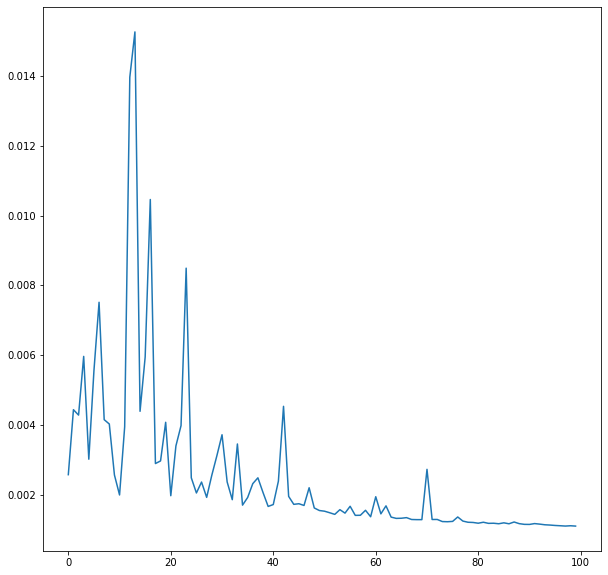

In [21]:
import numpy as np

loss_values = []
best_loss = float('inf')

for epoch in range(n_epoch):
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x).to(device)
        b_y = Variable(batch_y).to(device)

        y_pred = model(b_x.float())
        loss = torch.nn.MSELoss(reduction='mean')(y_pred, b_y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % eval_interval == 0:
        # evaluate model every $eval_interval$ steps
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test.float())
            e_loss = torch.nn.MSELoss(reduction='mean')(y_pred, y_test.float())
            loss_values.append(e_loss.cpu())

            y_err = (y_pred-y_test).cpu().data.numpy()
            y_abs_err = np.abs(y_err).max(axis=0)
            logging.info(f"epoch {epoch+1}: Train loss={loss:.4f}, Eval loss={e_loss:.4f}, Max_err={max(y_abs_err):.4f}, M1_err={y_abs_err[0]:.4f}, M2_err={y_abs_err[1]:.4f}")
            if e_loss < best_loss:
                best_loss = e_loss
                save_model(model, save_path + f"model_{epoch+1}_{e_loss:.4f}.pt")

        model.train()
    lr_scheduler.step()

save_model(model, save_path + f"model_final_{loss:.4f}.pt")
print(f"Final epoch loss={e_loss}")

fig = plt.figure(figsize=(10, 10))
plt.plot(loss_values)

In [22]:
import numpy as np

# np.savetxt(f"", loss_values, delimiter =", ", fmt='%s')

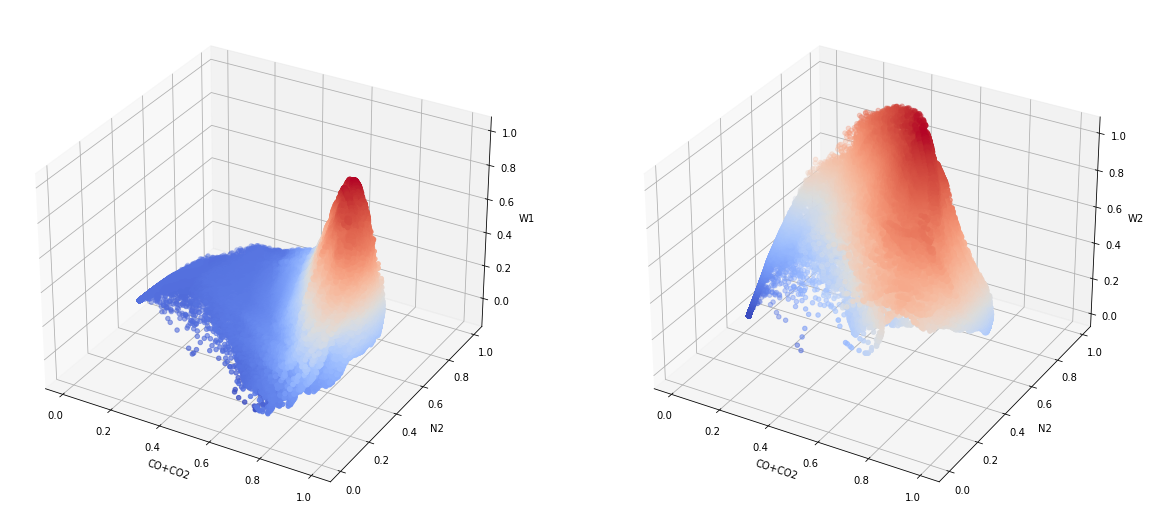

In [24]:
plot_3d_subplot(X_test[:, :2].cpu().data.numpy(), y_pred.cpu().data.numpy(), f"result/flame2-ann2-loss={e_loss:.6f}.png")

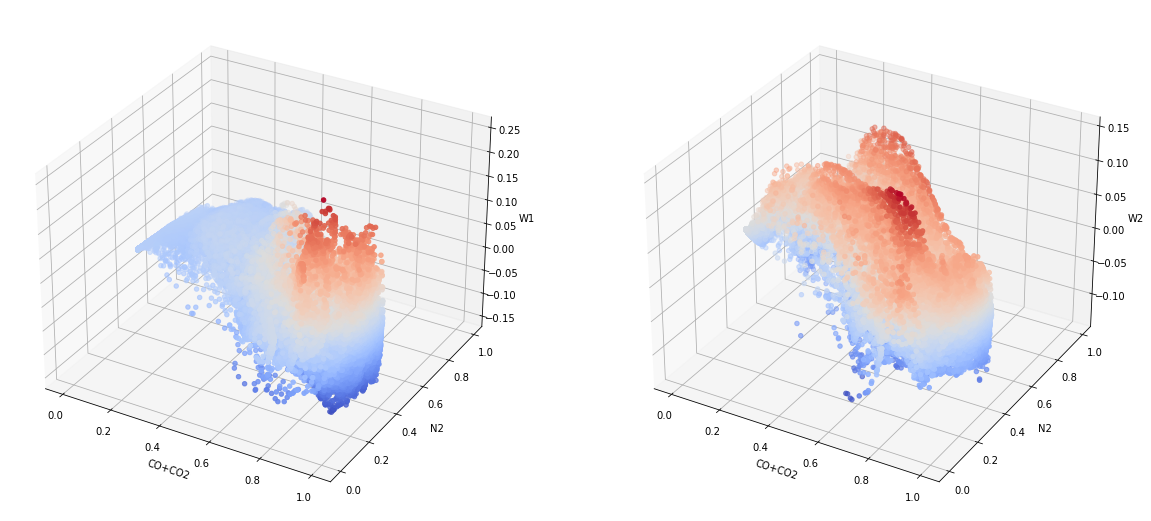

In [25]:
plot_3d_subplot(X_test[:, :2].cpu().data.numpy(), y_err, f"result/flame2-ann2-err-loss={e_loss:.6f}.png")

In [26]:
std_err = np.abs(y_err).max(axis=0)

In [28]:
print("loss value\tMax err\tW1 err\tW2 err\tRelative loss")
print(f"{e_loss}\t{max(std_err)}\t{std_err[0]}\t{std_err[1]}\t{e_loss.cpu().data.numpy()/len(y_err)*2752683}")

loss value	Max err	W1 err	W2 err	Relative loss
0.0010948027484118938	0.6124656363288447	0.24347712070536198	0.14303551377376655	0.0218959197435732
